## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data & Drop NaN Values

In [2]:
df = pd.read_csv("C:/Users/park9/pytorch/AI_class/data/WISDM_ar_v1.1_raw.txt",
                header=None,
                names=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'],
                on_bad_lines='skip')

df['z'] = df['z'].astype(str).str.replace(";", "", regex=False).astype(float)

df.head()

,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Drop NaN Values

In [3]:
print(df.isna().sum())
df = df.dropna()

user_id      0
activity     0
timestamp    0
x            0
y            0
z            1
dtype: int64


## Visualization

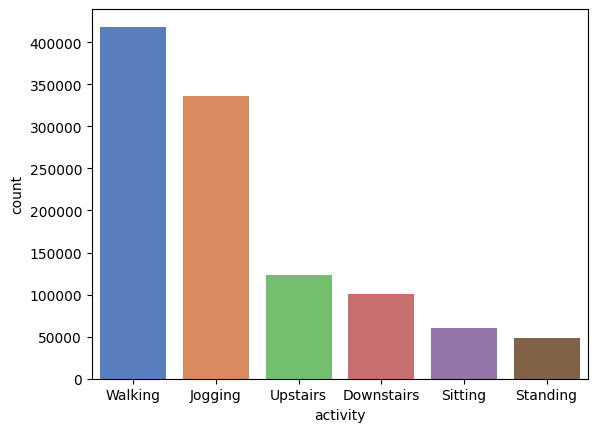

In [4]:
sns.countplot(x='activity', data=df, order = df['activity'].value_counts().index, palette="muted")
plt.show()

## Data Split

In [5]:
df_train = df[df['user_id'] <= 27].copy()
df_test = df[df['user_id'] > 27].copy()

In [6]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1086465, 6)
(801685, 6)
(284780, 6)


## Encoding & Normalization

In [7]:
# Label Encoding
num_cols = ["x", "y", "z"]

le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["activity"])
df_test["label"]  = le.transform(df_test["activity"])

# RobustScaler
scaler = RobustScaler()
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_test[num_cols]  = scaler.transform(df_test[num_cols])

## Sliding Windows

In [8]:
def create_sliding_windows_with_group(df, window_size=80, step_size=40):
    data, labels, groups = [], [], []
    values = df[["x", "y", "z"]].values
    acts   = df["label"].values
    users  = df["user_id"].values

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = values[start:end]
        label  = np.argmax(np.bincount(acts[start:end]))
        user   = users[start]

        data.append(window)
        labels.append(label)
        groups.append(user)

    return np.array(data), np.array(labels), np.array(groups)

X, y, groups = create_sliding_windows_with_group(df_train)
X_test, y_test, groups_test = create_sliding_windows_with_group(df_test)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)
test_ds  = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("전체:", X.shape, y.shape, groups.shape)

전체: (20041, 80, 3) (20041,) (20041,)


## GroupKFold

In [9]:
gkf = GroupKFold(n_splits=5)

def get_fold_loaders(fold, batch_size=64):
    train_idx, val_idx = list(gkf.split(X, y, groups))[fold]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val     = X[val_idx], y[val_idx]

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

## Model Creation

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=2, num_classes=6, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout,
                            bidirectional=False)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)     # (batch, seq_len, hidden_dim)
        out = out[:, -1, :]       # 마지막 타임스텝만 사용
        return F.log_softmax(self.fc(out), dim=1)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(num_classes=6).to(device)
print(device)
print(model)

cuda
LSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


## Model Training

In [13]:
def train_model(model, train_loader, val_loader, epochs=10):

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, epochs+1):
        # --- Training ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * xb.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
        
        train_acc = correct / total
        train_loss /= total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(yb).sum().item()
                val_total += yb.size(0)
        
        val_acc = val_correct / val_total
        val_loss /= val_total

        # --- 로그 저장 ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)   
        
        print(f"Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")   

    return history


===== Fold 1 =====
Epoch 01 | Train Loss: 1.4531, Acc: 0.4279 | Val Loss: 1.4598, Acc: 0.3606
Epoch 02 | Train Loss: 1.2238, Acc: 0.5427 | Val Loss: 0.9899, Acc: 0.6366
Epoch 03 | Train Loss: 0.9742, Acc: 0.6543 | Val Loss: 0.9006, Acc: 0.6451
Epoch 04 | Train Loss: 0.8353, Acc: 0.6958 | Val Loss: 0.7990, Acc: 0.7467
Epoch 05 | Train Loss: 0.7497, Acc: 0.7264 | Val Loss: 0.8143, Acc: 0.6645
Epoch 06 | Train Loss: 0.6769, Acc: 0.7321 | Val Loss: 0.8033, Acc: 0.7355
Epoch 07 | Train Loss: 0.5857, Acc: 0.7796 | Val Loss: 0.8030, Acc: 0.7237
Epoch 08 | Train Loss: 0.5407, Acc: 0.8140 | Val Loss: 0.8223, Acc: 0.7465
Epoch 09 | Train Loss: 0.5368, Acc: 0.8226 | Val Loss: 0.8072, Acc: 0.7900
Epoch 10 | Train Loss: 0.4065, Acc: 0.8660 | Val Loss: 0.8245, Acc: 0.7641
Epoch 11 | Train Loss: 0.3757, Acc: 0.8787 | Val Loss: 0.8347, Acc: 0.7813
Epoch 12 | Train Loss: 0.3567, Acc: 0.8859 | Val Loss: 0.6586, Acc: 0.8305
Epoch 13 | Train Loss: 0.2787, Acc: 0.9143 | Val Loss: 0.7644, Acc: 0.8031
Epoch

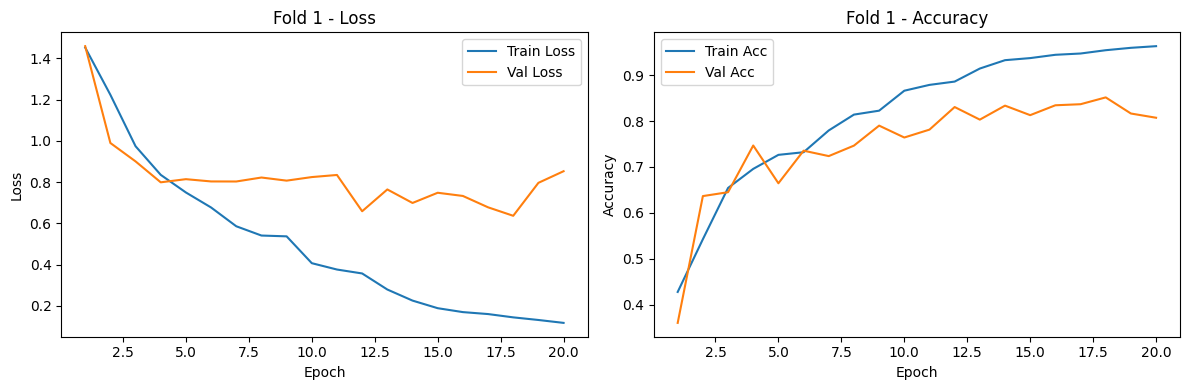

Fold 1 Accuracy: 0.8072

===== Fold 2 =====
Epoch 01 | Train Loss: 1.3792, Acc: 0.4472 | Val Loss: 1.4228, Acc: 0.4788
Epoch 02 | Train Loss: 1.1266, Acc: 0.6221 | Val Loss: 1.4565, Acc: 0.4362
Epoch 03 | Train Loss: 0.8487, Acc: 0.7248 | Val Loss: 1.0982, Acc: 0.6169
Epoch 04 | Train Loss: 0.7003, Acc: 0.7642 | Val Loss: 0.8434, Acc: 0.6619
Epoch 05 | Train Loss: 0.6267, Acc: 0.7727 | Val Loss: 0.6922, Acc: 0.7849
Epoch 06 | Train Loss: 0.5784, Acc: 0.7950 | Val Loss: 0.7290, Acc: 0.7255
Epoch 07 | Train Loss: 0.5401, Acc: 0.8086 | Val Loss: 0.7524, Acc: 0.6880
Epoch 08 | Train Loss: 0.4926, Acc: 0.8386 | Val Loss: 0.7504, Acc: 0.7511
Epoch 09 | Train Loss: 0.3883, Acc: 0.8733 | Val Loss: 0.8228, Acc: 0.7131
Epoch 10 | Train Loss: 0.3537, Acc: 0.8907 | Val Loss: 0.7437, Acc: 0.7298
Epoch 11 | Train Loss: 0.3433, Acc: 0.8935 | Val Loss: 0.9019, Acc: 0.6870
Epoch 12 | Train Loss: 0.3014, Acc: 0.9134 | Val Loss: 0.7689, Acc: 0.7346
Epoch 13 | Train Loss: 0.2520, Acc: 0.9238 | Val Loss: 0

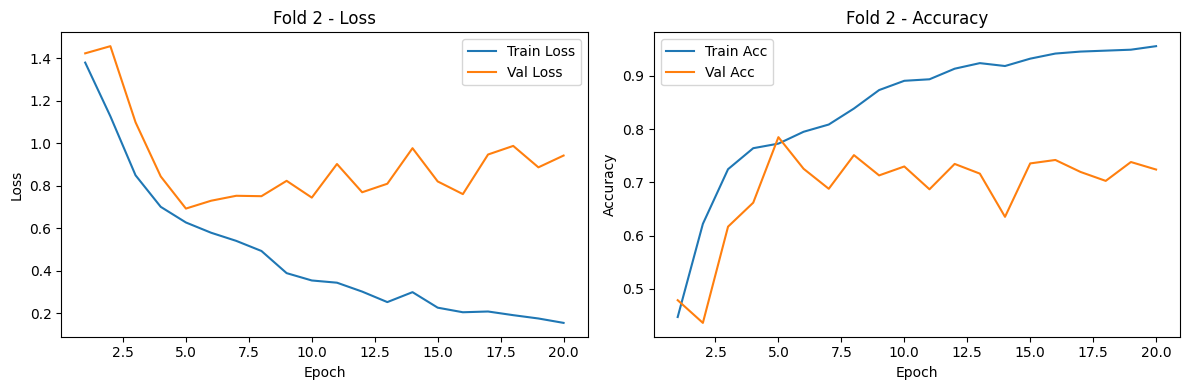

Fold 2 Accuracy: 0.7241

===== Fold 3 =====
Epoch 01 | Train Loss: 1.4440, Acc: 0.3665 | Val Loss: 1.4245, Acc: 0.3889
Epoch 02 | Train Loss: 1.3033, Acc: 0.4542 | Val Loss: 1.4858, Acc: 0.3651
Epoch 03 | Train Loss: 1.1477, Acc: 0.5577 | Val Loss: 1.1731, Acc: 0.5755
Epoch 04 | Train Loss: 0.9079, Acc: 0.6726 | Val Loss: 0.9397, Acc: 0.6982
Epoch 05 | Train Loss: 0.7955, Acc: 0.7155 | Val Loss: 0.8766, Acc: 0.7138
Epoch 06 | Train Loss: 0.7144, Acc: 0.7411 | Val Loss: 0.9002, Acc: 0.6662
Epoch 07 | Train Loss: 0.6572, Acc: 0.7499 | Val Loss: 0.8708, Acc: 0.7299
Epoch 08 | Train Loss: 0.6035, Acc: 0.7820 | Val Loss: 0.7374, Acc: 0.6741
Epoch 09 | Train Loss: 0.5604, Acc: 0.7937 | Val Loss: 0.8180, Acc: 0.6846
Epoch 10 | Train Loss: 0.5208, Acc: 0.8104 | Val Loss: 0.7014, Acc: 0.7199
Epoch 11 | Train Loss: 0.4678, Acc: 0.8294 | Val Loss: 0.6505, Acc: 0.7558
Epoch 12 | Train Loss: 0.3622, Acc: 0.8655 | Val Loss: 0.5111, Acc: 0.8126
Epoch 13 | Train Loss: 0.3175, Acc: 0.8891 | Val Loss: 0

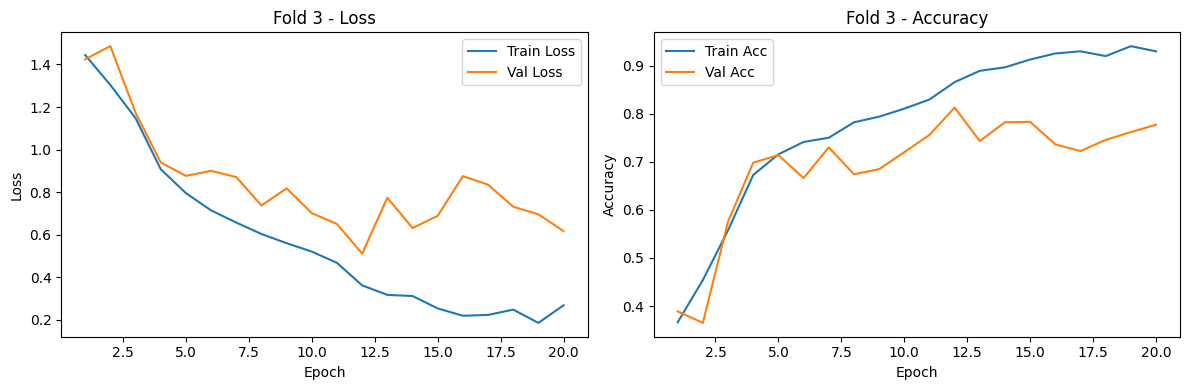

Fold 3 Accuracy: 0.7770

===== Fold 4 =====
Epoch 01 | Train Loss: 1.3654, Acc: 0.4353 | Val Loss: 1.4071, Acc: 0.5050
Epoch 02 | Train Loss: 1.0707, Acc: 0.5970 | Val Loss: 2.3130, Acc: 0.1730
Epoch 03 | Train Loss: 0.8623, Acc: 0.7039 | Val Loss: 1.2443, Acc: 0.5717
Epoch 04 | Train Loss: 0.7594, Acc: 0.7193 | Val Loss: 1.6180, Acc: 0.3863
Epoch 05 | Train Loss: 0.6897, Acc: 0.7500 | Val Loss: 1.7803, Acc: 0.3925
Epoch 06 | Train Loss: 0.5952, Acc: 0.7825 | Val Loss: 1.8478, Acc: 0.4743
Epoch 07 | Train Loss: 0.5587, Acc: 0.8005 | Val Loss: 1.4522, Acc: 0.4952
Epoch 08 | Train Loss: 0.5032, Acc: 0.8121 | Val Loss: 1.4317, Acc: 0.5113
Epoch 09 | Train Loss: 0.4898, Acc: 0.8193 | Val Loss: 1.4506, Acc: 0.5091
Epoch 10 | Train Loss: 0.3880, Acc: 0.8506 | Val Loss: 1.2631, Acc: 0.5751
Epoch 11 | Train Loss: 0.3471, Acc: 0.8651 | Val Loss: 1.1727, Acc: 0.5964
Epoch 12 | Train Loss: 0.3201, Acc: 0.8784 | Val Loss: 1.0015, Acc: 0.6828
Epoch 13 | Train Loss: 0.2570, Acc: 0.9113 | Val Loss: 1

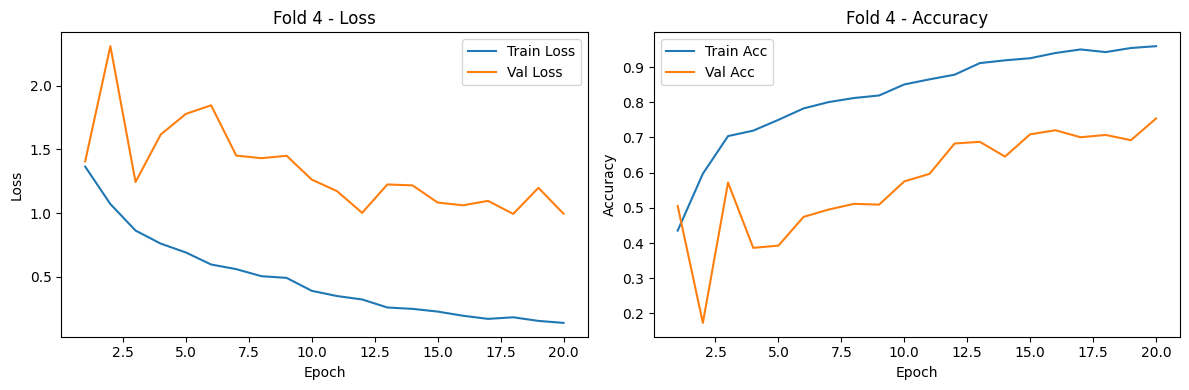

Fold 4 Accuracy: 0.7538

===== Fold 5 =====
Epoch 01 | Train Loss: 1.4096, Acc: 0.3434 | Val Loss: 1.2926, Acc: 0.6212
Epoch 02 | Train Loss: 1.2326, Acc: 0.5040 | Val Loss: 1.4241, Acc: 0.3963
Epoch 03 | Train Loss: 0.9808, Acc: 0.6337 | Val Loss: 0.9259, Acc: 0.7010
Epoch 04 | Train Loss: 0.7752, Acc: 0.7097 | Val Loss: 0.7525, Acc: 0.7087
Epoch 05 | Train Loss: 0.7466, Acc: 0.7168 | Val Loss: 0.8387, Acc: 0.6217
Epoch 06 | Train Loss: 0.6018, Acc: 0.7664 | Val Loss: 0.6071, Acc: 0.7721
Epoch 07 | Train Loss: 0.7413, Acc: 0.7537 | Val Loss: 0.6968, Acc: 0.7280
Epoch 08 | Train Loss: 0.5556, Acc: 0.7979 | Val Loss: 0.5421, Acc: 0.8076
Epoch 09 | Train Loss: 0.4575, Acc: 0.8447 | Val Loss: 0.6399, Acc: 0.7561
Epoch 10 | Train Loss: 0.3615, Acc: 0.8787 | Val Loss: 0.4822, Acc: 0.8179
Epoch 11 | Train Loss: 0.3357, Acc: 0.8885 | Val Loss: 0.3460, Acc: 0.8715
Epoch 12 | Train Loss: 0.2759, Acc: 0.9130 | Val Loss: 0.3379, Acc: 0.8633
Epoch 13 | Train Loss: 0.2544, Acc: 0.9192 | Val Loss: 0

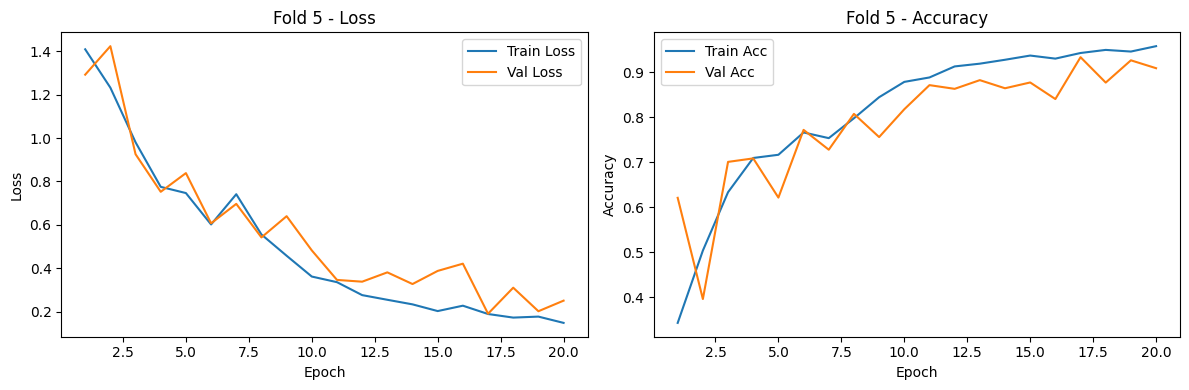

Fold 5 Accuracy: 0.9091

=== K-Fold 평균 정확도 ===
Mean Acc: 0.7942, Std: 0.0636


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_val_acc = 0.0
best_model_state = None
best_class_weights = None


fold_accs = []
for fold in range(5):
    print(f"\n===== Fold {fold+1} =====")
    train_loader, val_loader = get_fold_loaders(fold, batch_size=64)
    
    model = LSTMModel(num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 클래스 가중치 (train fold 기준)
    y_train_fold = np.array([y for _, y in train_loader.dataset])
    classes, counts = np.unique(y_train_fold, return_counts=True)
    weights = (counts.sum() / (len(classes) * counts)).astype(np.float32)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # 학습 (히스토리 저장)
    history = train_model(model, train_loader, val_loader, epochs=20)

    # fold 최고 성능 기록
    val_acc = max(history["val_acc"])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        best_class_weights = class_weights

    # 시각화
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))

    # Loss 곡선
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(False)

    # Accuracy 곡선
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()
    
    # fold 성능 저장
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(yb).sum().item()
            val_total += yb.size(0)
    acc = val_correct / val_total
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    fold_accs.append(acc)

print("\n=== K-Fold 평균 정확도 ===")
print(f"Mean Acc: {np.mean(fold_accs):.4f}, Std: {np.std(fold_accs):.4f}")

## Check class distribution by Fold

In [16]:
# Fold별 class 분포 확인
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    print(f"\nFold {fold+1} Validation Set Class Distribution:")
    for cls_idx, ratio in counts.items():
        print(f"  Class {cls_idx}: {ratio:.2%}")


Fold 1 Validation Set Class Distribution:
  Class 0: 8.32%
  Class 1: 30.35%
  Class 2: 13.55%
  Class 3: 6.84%
  Class 4: 8.94%
  Class 5: 32.01%

Fold 2 Validation Set Class Distribution:
  Class 0: 6.96%
  Class 1: 30.82%
  Class 2: 4.19%
  Class 3: 3.59%
  Class 4: 9.52%
  Class 5: 44.92%

Fold 3 Validation Set Class Distribution:
  Class 0: 7.94%
  Class 1: 35.69%
  Class 2: 3.81%
  Class 3: 4.97%
  Class 4: 9.83%
  Class 5: 37.76%

Fold 4 Validation Set Class Distribution:
  Class 0: 10.68%
  Class 1: 28.77%
  Class 2: 3.02%
  Class 3: 1.92%
  Class 4: 15.76%
  Class 5: 39.85%

Fold 5 Validation Set Class Distribution:
  Class 0: 10.76%
  Class 1: 35.05%
  Class 2: 1.80%
  Class 3: 2.86%
  Class 4: 12.41%
  Class 5: 37.11%


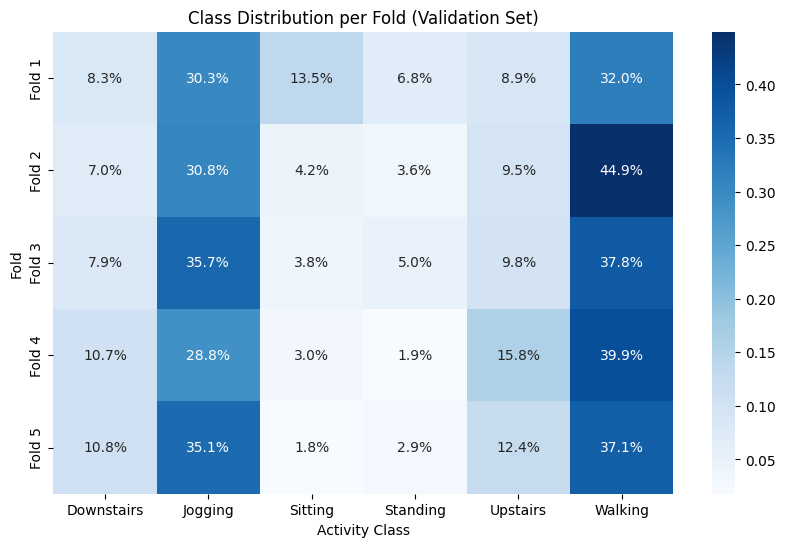

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

dist_per_fold = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    dist_per_fold.append(counts)

dist_df = pd.DataFrame(dist_per_fold).fillna(0)
dist_df.index = [f"Fold {i+1}" for i in range(len(dist_df))]
dist_df.columns = le.classes_  # activity 이름으로 열 바꾸기

plt.figure(figsize=(10,6))
sns.heatmap(dist_df, annot=True, fmt=".1%", cmap="Blues")
plt.title("Class Distribution per Fold (Validation Set)")
plt.ylabel("Fold")
plt.xlabel("Activity Class")
plt.show()

## Model Evaluation

In [18]:
# test
def test_loop(model, test_loader, criterion, device="cpu"):
    model.eval()  # 평가 모드 (Dropout/BatchNorm 비활성화)
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():  # 테스트 시에는 gradient 계산 끔
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            # forward
            outputs = model(xb)
            loss = criterion(outputs, yb)

            # 손실 누적 (평균 내기 위해 샘플 수 곱해줌)
            test_loss += loss.item() * xb.size(0)

            # 예측값
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    
    avg_loss = test_loss / total
    acc = correct / total
    return avg_loss, acc, np.array(all_preds), np.array(all_labels)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel(num_classes=6).to(device)
model.load_state_dict(best_model_state)

criterion = nn.CrossEntropyLoss(weight=best_class_weights)

test_loss, test_acc, all_preds, all_labels = test_loop(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.9288, Test Accuracy: 0.7829


In [21]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

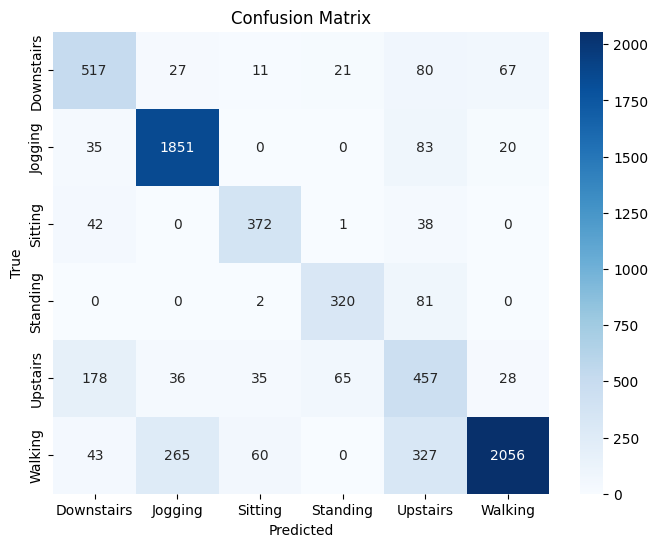

In [22]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [23]:
print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

  Downstairs       0.63      0.72      0.67       723
     Jogging       0.85      0.93      0.89      1989
     Sitting       0.78      0.82      0.80       453
    Standing       0.79      0.79      0.79       403
    Upstairs       0.43      0.57      0.49       799
     Walking       0.95      0.75      0.84      2751

    accuracy                           0.78      7118
   macro avg       0.74      0.76      0.75      7118
weighted avg       0.81      0.78      0.79      7118

